In this notebook i use IsolationForest and DBSCAN to detect fraud in credit card operations.

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.ensemble import IsolationForest

path_to_df='/kaggle/input/creditcardfraud/creditcard.csv'

In [2]:
df=pd.read_csv(path_to_df)

In [3]:
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


In [4]:
df.Class.value_counts()

Class
0    284315
1       492
Name: count, dtype: int64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

For memory usage purpouse taking only 20% of our data

In [6]:
X_bigger_part,X= train_test_split(df, test_size=0.30, random_state=42)

Scaling and PCA columns that are not scaled yet

In [7]:
scaler = StandardScaler()
X_bigger_part[['Time','Amount']] = scaler.fit_transform(X_bigger_part[['Time','Amount']])
X[['Time','Amount']] = scaler.fit_transform(X[['Time','Amount']])

In [8]:
pca = PCA()
X_bigger_part[['Time','Amount']] = pca.fit_transform(X_bigger_part[['Time','Amount']])
X[['Time','Amount']] = pca.fit_transform(X[['Time','Amount']])

Taking away teacher, cause we dont use it

In [9]:
y_bigger=X_bigger_part.iloc[:,-1:]
y_true=X.iloc[:,-1:]

X_80perc=X_bigger_part.iloc[:,0:-1]
X=X.iloc[:,0:-1]

In [10]:
anomalies = y_true['Class'].value_counts()[1]
print(f'There are {len(y_true)} rows in smaller part of df, with {anomalies} anomalies inside')

There are 85443 rows in smaller part of df, with 136 anomalies inside


Changing to float32 and numpy array for memory purpouse

In [11]:
X_80perc = X_80perc.astype('float32')
X = X.astype('float32')

X_80np = X_80perc.values.astype('float32')
Xnp = X.values.astype('float32')

PCA again, it improoves result a little bit

In [12]:
X_pca = PCA(n_components=0.95).fit_transform(Xnp)

# Assistant methods

This methods will give us full output report of model work

In [13]:
def y_final(y_df,y_pred):
  y=pd.concat([y_df.reset_index(drop=True), pd.Series(y_pred, name='y_pred')], axis=1)
  y['y_pred']=y['y_pred'].map({1:0,-1:1})
  y['end_pred']=y['y_pred']

  mask = (y['Class'] == 0) & (y['y_pred'] == 0)
  y.loc[mask, 'end_pred'] = 0
  mask = (y['Class'] == 1) & (y['y_pred'] == 1)
  y.loc[mask, 'end_pred'] = 1
  mask = (y['Class'] == 0) & (y['y_pred'] == 1)
  y.loc[mask, 'end_pred'] = 2
  mask = (y['Class'] == 1) & (y['y_pred'] == 0)
  y.loc[mask, 'end_pred'] = -1

  counts=y['end_pred'].value_counts()
  # For a more convenient view, we changing the order of the lines
  idx = list(counts.index)

  idx[0], idx[3] = idx[3], idx[0]
  counts = counts.loc[idx].reset_index(drop=True)
  return counts

In [14]:
def donut(counts):
  labels = [
      'Anomalies missed',
      'False anomalies',
      'Caught anomalies',
      'Normal transactions'
  ]
  colors = ['#ff6666', '#ffcc99', '#66b3ff', '#99ff99']
  fig, ax = plt.subplots(figsize=(8, 8))
  wedges, texts, autotexts = ax.pie(
      counts,
      explode=[0, 0.1, 0.1, 0.1],
      labels=labels,
      autopct='%1.1f%%',
      startangle=140,
      colors=colors,
      wedgeprops=dict(width=0.4)
  )
  for text in texts:
      text.set_fontsize(10)
  for autotext in autotexts:
      autotext.set_fontsize(9)
  plt.setp(autotexts, color='black')
  ax.set_title('Anomaly distribution', fontsize=14)
  ax.axis('equal')
  plt.tight_layout()
  plt.show()

In [15]:
def anomalies_report(y_df,y_pred):
  counts = y_final(y_df,y_pred)
  donut(counts)
  print('----'*20)
  print('----'*20)
  print(f'Length of y_df = {len(y_df)}, there is {counts[0]+counts[2]} anomalies')
  print(f'Anomaly detection predicted {counts[1]+counts[2]} anomalies, there is {counts[2]} predicted actual anomalies')
  print(f'There are {counts[3]} rows marked as normal, and {counts[0]} anomalies left in there')
  print('----'*20)
  print('----'*20)

# DBSCAN

In [16]:
model = DBSCAN(eps=3.7, min_samples=1000)
db = model.fit(X_pca)
y_dbscan_pred = db.labels_

Text(0.5, 1.0, 'DBSCAN Anomaly Detection')

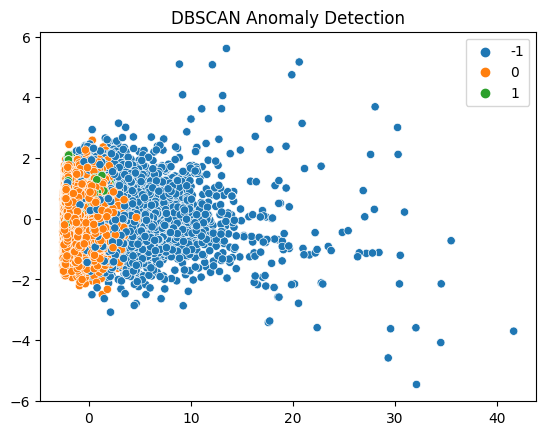

In [17]:
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, -1], hue=y_dbscan_pred, palette='tab10')
plt.title('DBSCAN Anomaly Detection')

In [18]:
y_dbscan_pred[y_dbscan_pred != -1] = 1

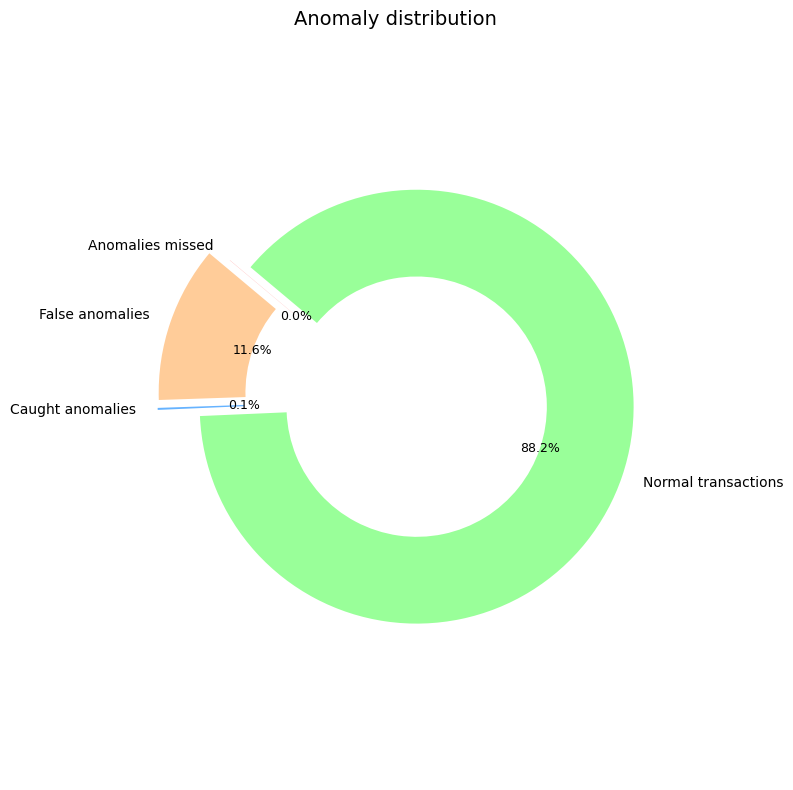

--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Length of y_df = 85443, there is 136 anomalies
Anomaly detection predicted 10074 anomalies, there is 127 predicted actual anomalies
There are 75360 rows marked as normal, and 9 anomalies left in there
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


In [19]:
anomalies_report(y_true,y_dbscan_pred)

# Isolation Forest

In [20]:
model = IsolationForest(n_estimators=300, contamination=0.09, random_state=42)
y_pred = model.fit_predict(X_pca)  # Предсказываем выбросы (-1) и нормальные точки (1)



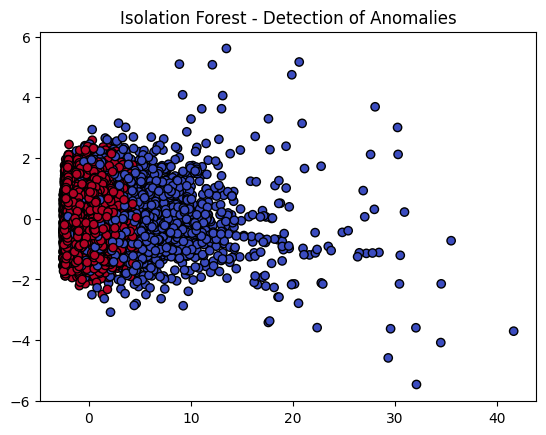

In [21]:
plt.scatter(X_pca[:, 0], X_pca[:, -1], c=y_pred, cmap='coolwarm', edgecolors='k')
plt.title("Isolation Forest - Detection of Anomalies")
plt.show()

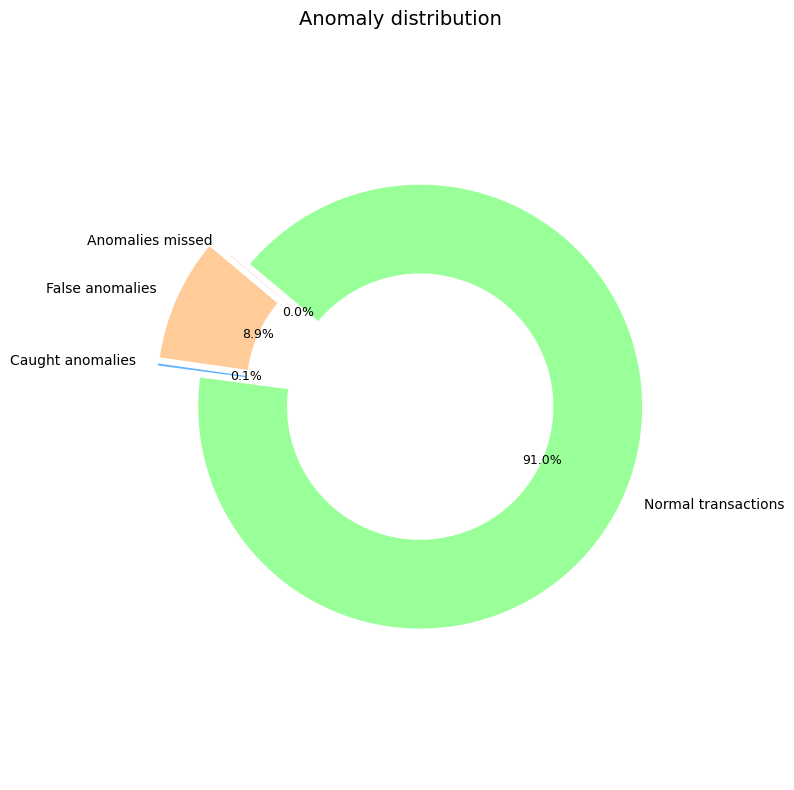

--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Length of y_df = 85443, there is 136 anomalies
Anomaly detection predicted 7690 anomalies, there is 126 predicted actual anomalies
There are 77743 rows marked as normal, and 10 anomalies left in there
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


In [22]:
anomalies_report(y_true,y_pred)

IsolationForest is more cofortable for me, cause you dont need to adjust parameters for each size.